In [76]:
import os
os.environ["OMP_NUM_THREADS"] = "2"
import sys
import copy
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import seaborn as sns
import geopandas as gpd

sys.path.append("../code")
from tree import *
from rules import *
from tree_rules import tree_to_rules
from distances import *
from rule_clustering import *
from utils import visualize_tree
from utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
mcolors.rgb2hex

<function matplotlib.colors.to_hex(c, keep_alpha=False)>

# Dataset

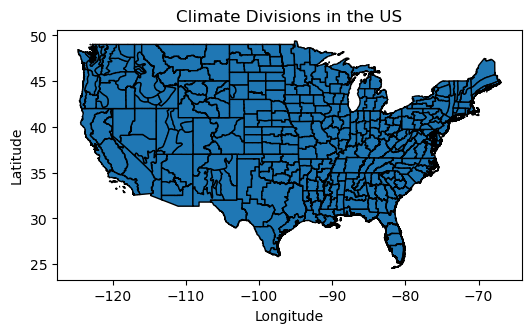

In [2]:
shapefile_path = '../data/climate/climate_divisions/GIS.OFFICIAL_CLIM_DIVISIONS.shp'
dtype_dict = {'CLIMDIV': 'str'}
gdf = gpd.read_file(shapefile_path, dtype = dtype_dict)
gdf['CLIMDIV'] = gdf['CLIMDIV'].apply(lambda x: f'{int(x):04d}')

gdf.plot(figsize=(6, 6), edgecolor='black')
plt.title('Climate Divisions in the US')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [3]:
climate_data = pd.read_csv('../data/climate/climate.csv', dtype={'ID': str, 'Year': str})
climate_data.set_index(['ID', 'Year'], inplace=True)

In [4]:
climate_data

pcpn_jan  pcpn_feb  pcpn_mar  pcpn_apr  pcpn_may  pcpn_june  \
ID   Year                                                                
0101 1895      7.37      1.41      7.17      2.72      3.06       4.04   
     1896      2.47      7.46      6.23      4.34      2.92       4.50   
     1897      3.85      3.74     14.40      4.99      2.87       2.12   
     1898      7.07      1.34      4.43      4.29      1.86       2.61   
     1899      5.79      6.39      9.93      2.99      1.50       2.22   
...             ...       ...       ...       ...       ...        ...   
5013 2020      3.21      4.60      2.03      1.40      2.04       1.94   
     2021      5.02      5.64      3.09      2.64      2.79       2.50   
     2022      3.44      7.17      2.51      2.76      0.70       2.34   
     2023      3.71      3.83      4.87      1.88      3.27       2.06   
     2024      5.53      3.97      4.03      3.44      2.36       1.80   

           pcpn_july  pcpn_aug  pcpn_sept  pcpn_oct  ...  temp_mar  temp_apr  \
ID   Year                                            ...                       
0101 1895       4.58      4.00       3.41      2.28  ...      50.3      61.2   
     1896       3.78      1.94       2.67      1.59  ...      47.8      65.7   
     1897       3.93      3.66       0.03      1.74  ...      55.2      60.0   
     1898       5.52      3.67       2.83      3.72  ...      56.0      55.4   
     1899       6.04      3.44       0.57      1.85  ...      51.0      59.1   
...              ...       ...        ...       ...  ...       ...       ...   
5013 2020       2.76      3.24       6.04      4.18  ...      33.2      38.6   
     2021       2.09      2.61       3.53      9.21  ...      31.9      36.8   
     2022       2.96      6.06       4.25      5.75  ...      30.5      34.9   
     2023       5.39      2.87       5.34      3.34  ...      33.1      34.2   
     2024       3.74     -9.99      -9.99     -9.99  ...      29.5      35.2   

           temp_may  temp_june  temp_july  temp_aug  temp_sept  temp_oct  \
ID   Year                                                                  
0101 1895      66.8       75.8       77.0      78.1       75.2      54.3   
     1896      73.8       74.8       79.9      80.8       72.0      58.6   
     1897      66.1       78.5       80.2      77.8       74.8      64.8   
     1898      71.8       79.1       79.8      78.5       74.6      58.5   
     1899      74.3       78.8       79.9      80.8       71.0      64.2   
...             ...        ...        ...       ...        ...       ...   
5013 2020      42.2       47.4       52.0      50.9       45.5      40.9   
     2021      41.3       46.7       50.7      51.8       47.3      39.7   
     2022      39.7       46.9       50.0      51.1       48.4      41.8   
     2023      39.0       46.1       51.9      52.4       48.3      42.3   
     2024      38.4       44.7       50.3     -99.9      -99.9     -99.9   

           temp_nov  temp_dec  
ID   Year                      
0101 1895      50.1      42.1  
     1896      52.9      42.7  
     1897      50.3      43.1  
     1898      46.4      39.6  
     1899      53.0      39.9  
...             ...       ...  
5013 2020      36.3      30.6  
     2021      29.2      34.7  
     2022      37.3      33.7  
     2023      37.3      28.1  
     2024     -99.9     -99.9  

[46020 rows x 24 columns]

In [5]:
historical_years = [str(i) for i in range(1900,2000)]
recent_years = [str(i) for i in range(2013,2024)]

historical = climate_data.loc[pd.IndexSlice[:, historical_years], :]
recent = climate_data.loc[pd.IndexSlice[:, recent_years], :]

historical_avg = historical.groupby(level='ID').mean()
recent_avg = recent.groupby(level='ID').mean()

climate_change = (recent_avg - historical_avg)/historical_avg
climate_change = climate_change.loc[gdf.CLIMDIV,:]

# Some extra code for filtering instances with large values:
#threshold = 10

# Create a boolean mask where any value in a row is greater than the threshold
#mask = ((climate_change > threshold) | (climate_change < -threshold)).any(axis=1)

# Filter the DataFrame based on the mask
#climate_change = climate_change[~mask]

In [7]:
# change months to seasons
groupings = {
    'pcpn_winter': ['pcpn_dec', 'pcpn_jan', 'pcpn_feb'],
    'pcpn_spring': ['pcpn_mar', 'pcpn_apr', 'pcpn_may'],
    'pcpn_summer': ['pcpn_june', 'pcpn_july', 'pcpn_aug'],
    'pcpn_fall': ['pcpn_sept', 'pcpn_oct', 'pcpn_nov'],
    'temp_winter': ['temp_dec', 'temp_jan', 'temp_feb'],
    'temp_spring': ['temp_mar', 'temp_apr', 'temp_may'],
    'temp_summer': ['temp_june', 'temp_july', 'temp_aug'],
    'temp_fall': ['temp_sept', 'temp_oct', 'temp_nov']
}

seasonal_historical = pd.DataFrame()
seasonal_recent = pd.DataFrame()
seasonal_climate_change = pd.DataFrame()

# Calculate the average for each group of months
for group_name, columns in groupings.items():
    seasonal_historical[group_name] = historical_avg[columns].mean(axis=1)
    seasonal_recent[group_name] = recent_avg[columns].mean(axis=1)
    seasonal_climate_change[group_name] = climate_change[columns].mean(axis=1)

In [8]:
seasonal_historical

,pcpn_winter,pcpn_spring,pcpn_summer,pcpn_fall,temp_winter,temp_spring,temp_summer,temp_fall
ID,,,,,,,,
0101,5.208833,5.118700,4.125933,3.592367,41.716667,59.578667,77.438333,60.925667
0102,5.314433,5.162533,4.401867,3.609000,42.635667,60.008667,77.241333,61.383333
0103,5.340000,5.206767,4.428200,3.478700,44.924667,61.980333,79.012000,63.254000
0104,5.224233,5.095900,4.393433,3.416367,44.082000,61.005000,77.897667,62.176667
0105,5.189033,5.023867,4.543633,3.308633,45.240333,61.518000,77.658000,62.821667
...,...,...,...,...,...,...,...,...
5009,13.857689,10.120978,10.006711,21.315156,19.553333,31.340444,47.329778,33.533333
5010,8.217911,4.691956,4.047156,11.359200,16.632889,31.261778,48.684000,32.447111
5011,13.948667,9.764489,9.559200,20.591067,21.542222,33.932000,48.621333,35.718667


In [9]:
seasonal_recent

,pcpn_winter,pcpn_spring,pcpn_summer,pcpn_fall,temp_winter,temp_spring,temp_summer,temp_fall
ID,,,,,,,,
0101,6.251212,5.433030,5.151515,3.427576,44.345455,60.390909,77.672727,62.160606
0102,6.298485,5.436061,5.086970,3.398485,45.403030,61.024242,77.509091,62.806061
0103,6.189091,5.587879,5.036364,3.186364,47.272727,62.678788,79.133333,64.378788
0104,6.141515,5.383333,5.046061,3.241818,46.857576,62.069697,78.536364,63.742424
0105,5.996667,5.210303,5.112727,3.402424,47.927273,62.378788,78.342424,63.975758
...,...,...,...,...,...,...,...,...
5009,14.187879,9.491515,11.591212,20.081212,22.418182,32.930303,49.512121,35.060606
5010,9.884242,4.724545,5.097879,11.014848,19.242424,32.212121,49.912121,33.345455
5011,16.500303,9.840000,11.726364,19.753333,24.333333,34.787879,49.860606,36.651515


In [10]:
seasonal_climate_change

,pcpn_winter,pcpn_spring,pcpn_summer,pcpn_fall,temp_winter,temp_spring,temp_summer,temp_fall
ID,,,,,,,,
2905,-0.099614,-0.309597,-0.001967,0.020584,0.060051,0.052568,0.037429,0.045353
2906,-0.191203,-0.252374,-0.009245,0.056216,0.068921,0.054392,0.042265,0.047781
1001,-0.042506,0.098920,-0.228816,-0.003981,0.094547,0.039393,0.053449,0.039010
1002,0.044702,0.037223,-0.300904,-0.043876,0.054939,0.032494,0.042860,0.027722
1004,-0.063988,0.005865,-0.210318,-0.027183,0.092534,0.048268,0.047014,0.040747
...,...,...,...,...,...,...,...,...
2907,-0.198821,-0.272502,-0.084641,0.157246,0.062033,0.044639,0.042814,0.043292
2901,0.053862,-0.219445,-0.150202,-0.093625,0.070714,0.046060,0.039634,0.044312
2902,0.020457,-0.201972,-0.052232,0.029766,0.077949,0.046263,0.031431,0.047987


<Axes: >

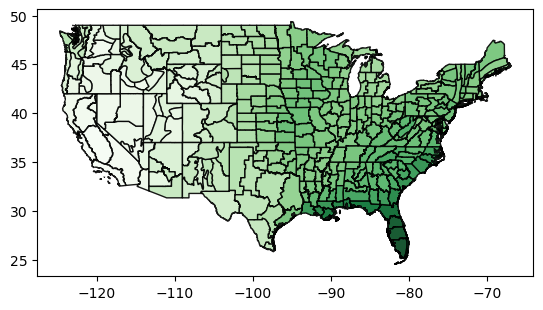

In [11]:
var = 'pcpn_summer'
val_array = np.empty(len(gdf))
val_array[:] = np.nan
for i,id in enumerate(seasonal_historical.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        val_array[idx[0]] = seasonal_historical.loc[id, var]

gdf['val'] = val_array
gdf.plot(column='val', cmap='Greens', legend=False, edgecolor = 'black', alpha = 0.9)

<Axes: >

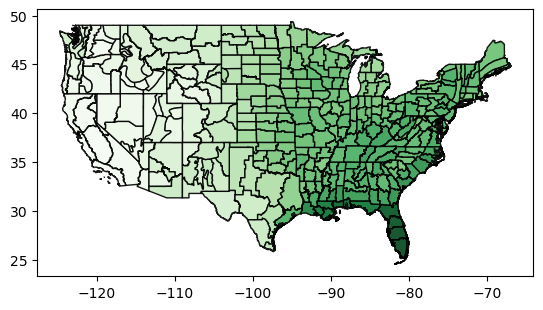

In [14]:
var = 'pcpn_summer'
val_array = np.empty(len(gdf))
val_array[:] = np.nan
for i,id in enumerate(seasonal_recent.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        val_array[idx[0]] = seasonal_recent.loc[id, var]
        
gdf['val'] = val_array
gdf.plot(column='val', cmap='Greens', legend=False, edgecolor = 'black', alpha = 0.9)

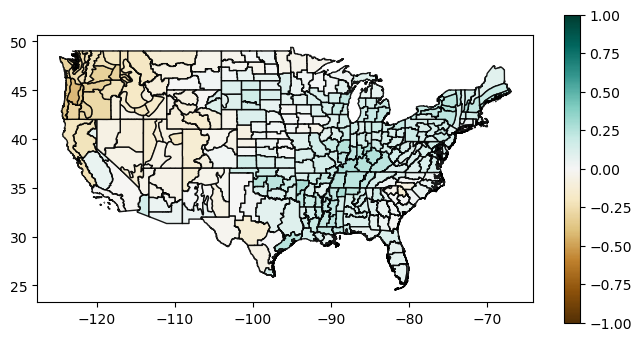

In [15]:
var = 'pcpn_summer'
val_array = np.empty(len(gdf))
val_array[:] = np.nan
for i,id in enumerate(seasonal_climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        val_array[idx[0]] = seasonal_climate_change.loc[id, var]
        
gdf['val'] = val_array

fig,ax = plt.subplots(figsize = (8,8))
gdf.plot(column='val', cmap='BrBG', ax = ax, vmin = -1, vmax = 1, legend=False, edgecolor = 'black', alpha = 0.9)
sm = plt.cm.ScalarMappable(cmap='BrBG', norm=plt.Normalize(vmin=-1, vmax=1))
sm._A = []
cbar = fig.colorbar(sm, ax=ax, shrink = 0.5)

# Clustering

In [12]:
def kmeans_cost(X):
    mu = np.mean(X, axis = 0)
    cost = np.sum(np.linalg.norm(X - mu, axis = 1)**2)
    return cost

def kmeans_labels_cost(X,y):
    total = 0
    for i, label in enumerate(np.unique(y)):
        idxs = np.where(y == label)[0]
        total += kmeans_cost(X[idxs,:])
        
    return total

In [29]:
data = climate_change.to_numpy()
#data = seasonal_climate_change.to_numpy()
feature_labels = climate_change.columns

## k-means

In [22]:
k_trials = list(range(2,41))
trial_scores = [-1]*len(k_trials)
for i,k in enumerate(k_trials):
    kmeans = KMeans(n_clusters=k, init = 'k-means++', n_init='auto').fit(data)
    trial_scores[i] = kmeans_labels_cost(data, kmeans.labels_)
    #trial_scores[i] = silhouette_score(data, kmeans.labels_)

Text(0, 0.5, 'cost')

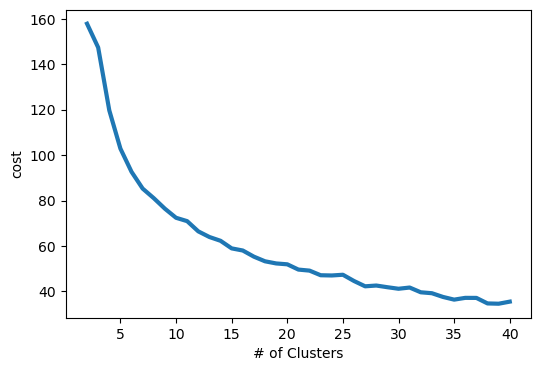

In [23]:
fig,ax = plt.subplots(figsize = (6,4))
ax.plot(k_trials, trial_scores, linewidth = 3)
ax.set_xlabel('# of Clusters')
ax.set_ylabel('cost')

In [24]:
k = 6
kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(data)

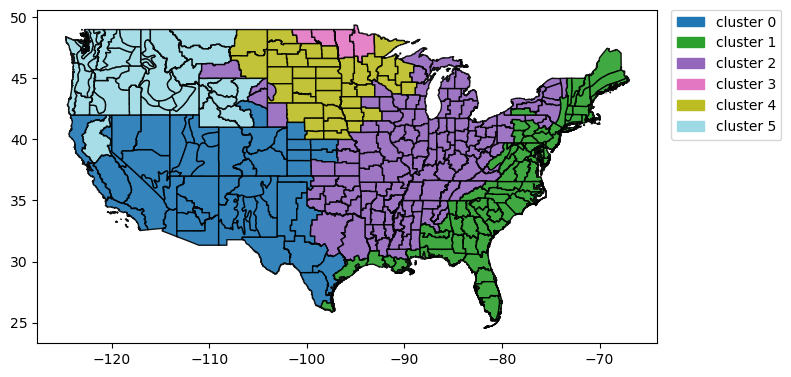

In [25]:
label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        label_array[idx[0]] = kmeans.labels_[i]

gdf['cluster'] = label_array

fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='cluster', cmap='tab20', ax = ax, legend=False, edgecolor = 'black', alpha = 0.9)

legend_labels = np.unique(label_array)
cmap = plt.get_cmap('tab20')
norm = mcolors.Normalize(vmin=np.min(legend_labels), vmax=np.max(legend_labels))

patches = [mpatches.Patch(color=cmap(norm(value)), label=f'cluster {int(value)}') for value in legend_labels]
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.2, 1), borderaxespad=0.)

## Rule Clustering

In [26]:
k = 6

#### k-means Tree Partition

In [24]:
leaves = list(range(k,37))
cost_by_leaves = []
for l in leaves:
    kmeans_tree = kMeansTree(max_leaf_nodes = l, min_points_leaf = 1)
    kmeans_tree.fit(data)
    kmeans_rules = tree_to_rules().traverse(kmeans_tree.root)

    cost_sum = 0
    for r in kmeans_rules:
        r.fit(data)
        cost_sum += kmeans_cost(r.satisfied_points)

    cost_by_leaves.append(cost_sum)

In [25]:
cost = kmeans_labels_cost(data, kmeans.labels_)
upper_bound = 4*cost + 6*np.array(cost_by_leaves)
dasgupta = k**2 * cost
svensson = k * (np.log(k)**2) * cost

Text(0, 0.5, 'Cost')

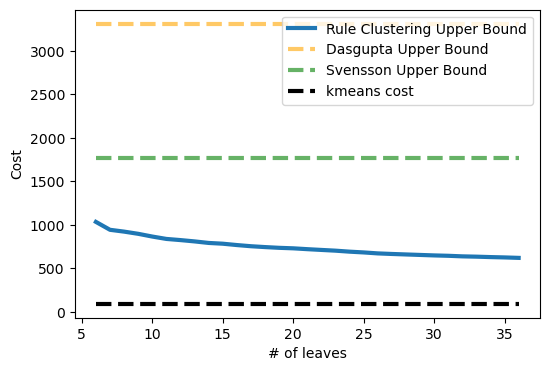

In [26]:
fig,ax = plt.subplots(figsize = (6,4))
plt.plot(leaves, upper_bound, linewidth = 3, label = 'Rule Clustering Upper Bound')
plt.hlines(dasgupta, xmin = leaves[0], xmax = leaves[-1], linestyle = '--', label = 'Dasgupta Upper Bound', linewidth = 3, color = 'orange', alpha = 0.6)
plt.hlines(svensson, xmin = leaves[0], xmax = leaves[-1], linestyle = '--', label = 'Svensson Upper Bound', linewidth = 3, color = 'green', alpha = 0.6)
plt.hlines(kmeans_labels_cost(data, kmeans.labels_), xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = '--', label = 'kmeans cost', linewidth = 3)
plt.legend()
ax.set_xlabel('# of leaves')
ax.set_ylabel('Cost')

In [43]:
kmeans_tree = kMeansTree(max_leaf_nodes = 12, min_points_leaf = 1)
kmeans_tree.fit(data, feature_labels)
kmeans_tree_labels = kmeans_tree.predict(data)
tree_traverse = tree_to_rules()
kmeans_tree_rules = tree_traverse.traverse(kmeans_tree.root)
leaf_node_labels = tree_traverse.leaf_node_labels

In [44]:
tree_to_rules().traverse(kmeans_tree.root)

[(temp_apr <= -0.0356369820655536  ∧  temp_jan <= 1.2232939474318787),
 (temp_apr <= -0.0356369820655536  ∧  temp_jan > 1.2232939474318787),
 (temp_apr > -0.0356369820655536  ∧  temp_june <= 0.03600812668405327  ∧  pcpn_feb <= 0.13330478404502616  ∧  temp_jan <= 0.03969656140292623  ∧  pcpn_aug <= 0.09240585111054267),
 (temp_apr > -0.0356369820655536  ∧  temp_june <= 0.03600812668405327  ∧  pcpn_feb <= 0.13330478404502616  ∧  temp_jan <= 0.03969656140292623  ∧  pcpn_aug > 0.09240585111054267),
 (temp_apr > -0.0356369820655536  ∧  temp_june <= 0.03600812668405327  ∧  pcpn_feb <= 0.13330478404502616  ∧  temp_jan > 0.03969656140292623  ∧  temp_apr <= 0.01620793806100326),
 (temp_apr > -0.0356369820655536  ∧  temp_june <= 0.03600812668405327  ∧  pcpn_feb <= 0.13330478404502616  ∧  temp_jan > 0.03969656140292623  ∧  temp_apr > 0.01620793806100326),
 (temp_apr > -0.0356369820655536  ∧  temp_june <= 0.03600812668405327  ∧  pcpn_feb > 0.13330478404502616  ∧  pcpn_sept <= -0.093328455265363),


In [45]:
leaf_node_labels

[1, 11, 3, 7, 2, 10, 5, 6, 8, 0, 9, 4]

#### Rule constrained k-means

In [46]:
rule_kmeans = kMeansRuleClustering(kmeans_tree_rules, k_clusters = 6, init = 'k-means')
rule_kmeans.fit(data)
point_labels, rule_labels = rule_kmeans.predict(data)

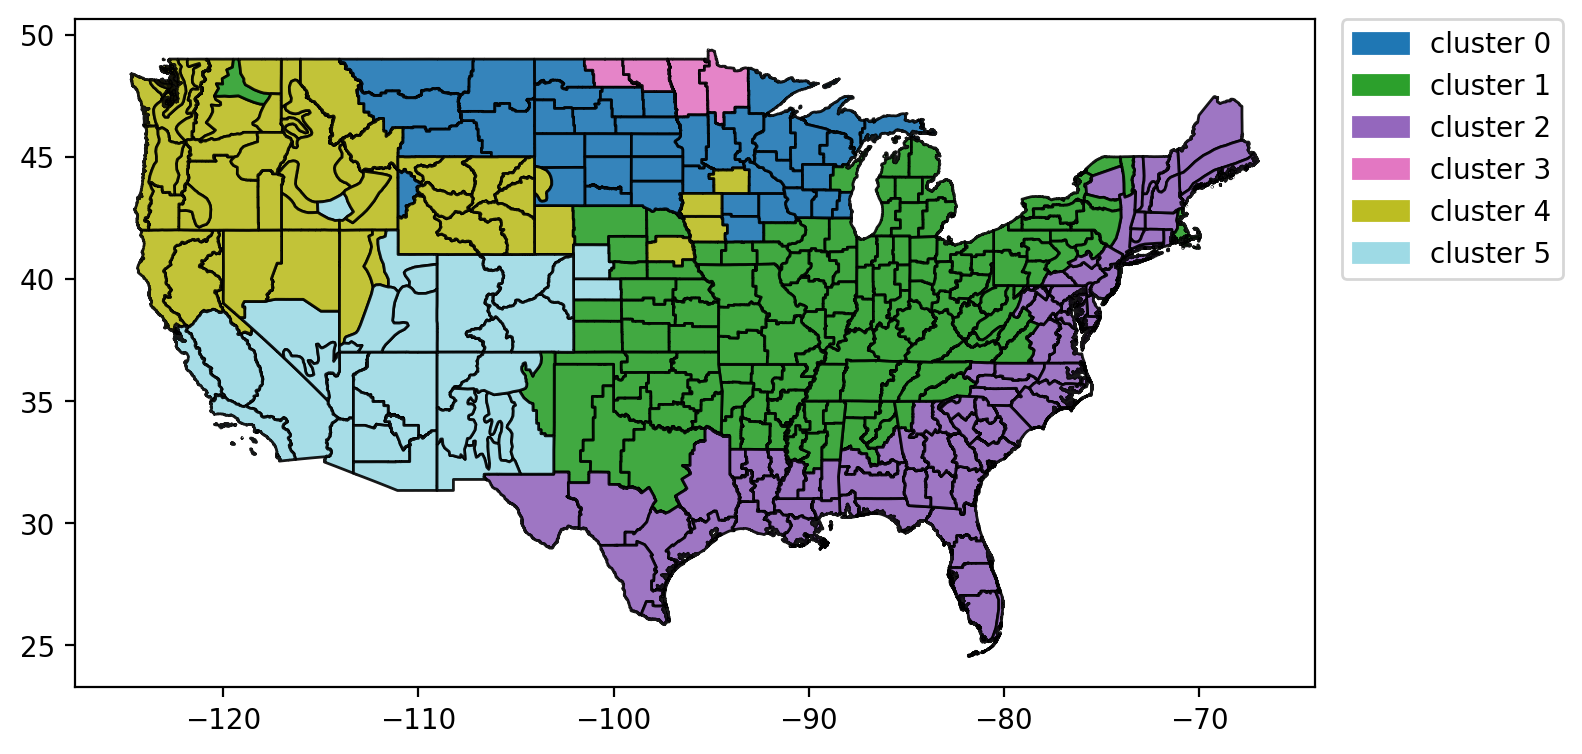

In [72]:
label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        label_array[idx[0]] = point_labels[i]

gdf['cluster'] = label_array

fig,ax = plt.subplots(figsize=(8,8), dpi = 200)
gdf.plot(column='cluster', cmap='tab20', ax = ax, legend=False, edgecolor = 'black', alpha = 0.9)

legend_labels = np.unique(label_array)
cmap = plt.get_cmap('tab20')
norm = mcolors.Normalize(vmin=np.min(legend_labels), vmax=np.max(legend_labels))

patches = [mpatches.Patch(color=cmap(norm(value)), label=f'cluster {int(value)}') for value in legend_labels]
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.2, 1), borderaxespad=0.)

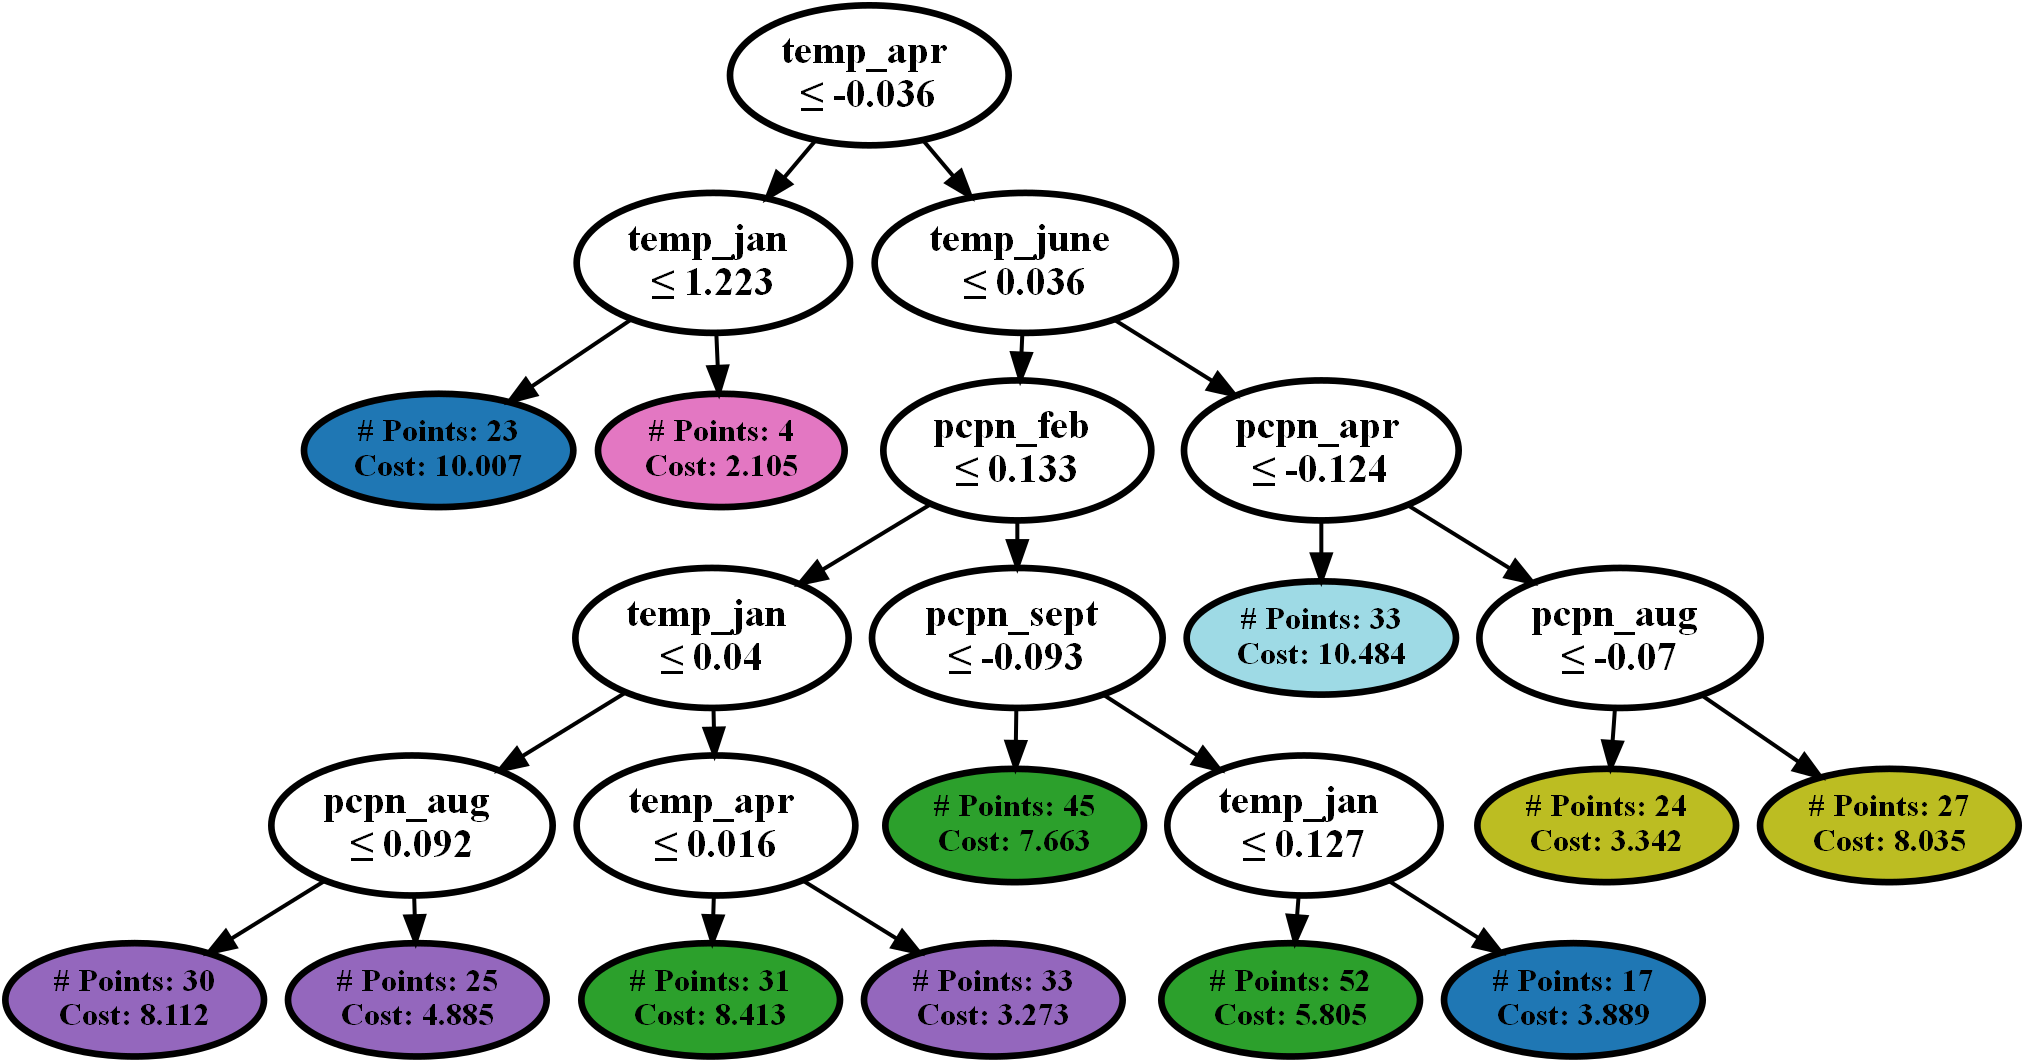

In [82]:
leaf_colors = {leaf_node_labels[i]:mcolors.rgb2hex(cmap(norm(rule_labels[i])), keep_alpha=True) for i in range(len(leaf_node_labels))}
visualize_tree(kmeans_tree.root, feature_labels = feature_labels, leaf_colors = leaf_colors)

In [31]:
print(rule_kmeans)

IF:
(temp_apr <= -0.0356369820655536  ∧  temp_jan <= 1.2232939474318787)  ∨  
(temp_apr > -0.0356369820655536  ∧  temp_june <= 0.03600812668405327  ∧  pcpn_feb > 0.13330478404502616  ∧  pcpn_sept > -0.093328455265363  ∧  temp_jan > 0.12730894603404552)
THEN CLUSTER 0

IF:
(temp_apr > -0.0356369820655536  ∧  temp_june <= 0.03600812668405327  ∧  pcpn_feb <= 0.13330478404502616  ∧  temp_jan > 0.03969656140292623  ∧  temp_apr <= 0.01620793806100326)  ∨  
(temp_apr > -0.0356369820655536  ∧  temp_june <= 0.03600812668405327  ∧  pcpn_feb > 0.13330478404502616  ∧  pcpn_sept <= -0.093328455265363)  ∨  
(temp_apr > -0.0356369820655536  ∧  temp_june <= 0.03600812668405327  ∧  pcpn_feb > 0.13330478404502616  ∧  pcpn_sept > -0.093328455265363  ∧  temp_jan <= 0.12730894603404552)
THEN CLUSTER 1

IF:
(temp_june <= 0.03600812668405327  ∧  pcpn_feb <= 0.13330478404502616  ∧  temp_jan > 0.03969656140292623  ∧  temp_apr > 0.01620793806100326)  ∨  
(temp_apr > -0.0356369820655536  ∧  temp_june <= 0.036008

In [88]:
leaves = list(range(k,37))
cost_by_leaves1 = []
iterations1 = []
cost_by_leaves2 = []
iterations2 = []
for l in leaves:
    kmeans_tree = kMeansTree(max_leaf_nodes = l, min_points_leaf = 1)
    kmeans_tree.fit(data)
    kmeans_rules = tree_to_rules().traverse(kmeans_tree.root)
    
    rule_kmeans1 = kMeansRuleClustering(kmeans_rules, k_clusters = k, init = 'k-means')
    rule_kmeans1.fit(data)
    point_labels1, rule_labels1 = rule_kmeans1.predict(data)
    iterations1.append(rule_kmeans1.iterations)

    rule_kmeans2 = kMeansRuleClustering(kmeans_rules, k_clusters = k, init = 'k-means++')
    rule_kmeans2.fit(data)
    point_labels2, rule_labels2 = rule_kmeans2.predict(data)
    iterations2.append(rule_kmeans1.iterations)

    cluster_cost = kmeans_labels_cost(data, point_labels1)
    cost_by_leaves1.append(cluster_cost)

    cluster_cost = kmeans_labels_cost(data, point_labels2)
    cost_by_leaves2.append(cluster_cost)

In [33]:
# Svensson Random Tree for comparison:
random_tree_cost = np.inf
for i in range(10000):
    random_tree = RandomTree(max_leaf_nodes = k, min_points_leaf = 1)
    random_tree.fit(kmeans.cluster_centers_)
    random_tree_labels = random_tree.predict(data)
    rcost = kmeans_labels_cost(data, random_tree_labels)
    if rcost < random_tree_cost:
        random_tree_cost = rcost

Text(0, 0.5, 'cost')

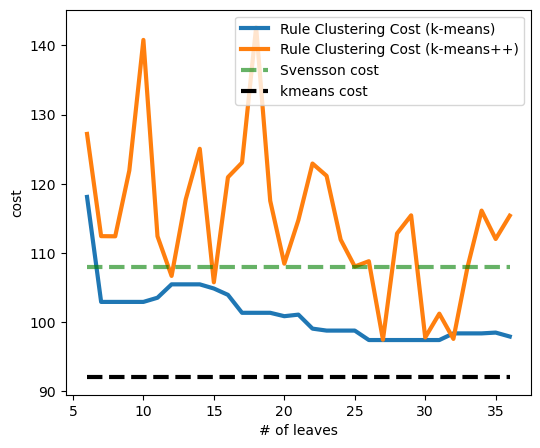

In [34]:
fig,ax = plt.subplots(figsize = (6,5))
ax.plot(leaves, cost_by_leaves1, linewidth = 3, label = 'Rule Clustering Cost (k-means)')
ax.plot(leaves, cost_by_leaves2, linewidth = 3, label = 'Rule Clustering Cost (k-means++)')
ax.hlines(random_tree_cost, xmin = leaves[0], xmax = leaves[-1], color = 'green', linestyle = '--', label = 'Svensson cost', linewidth = 3, alpha = 0.6)
ax.hlines(kmeans_labels_cost(data, kmeans.labels_), xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = '--', label = 'kmeans cost', linewidth = 3)
plt.legend()
ax.set_xlabel('# of leaves')
ax.set_ylabel('cost')

Text(0, 0.5, '# of cluster updates')

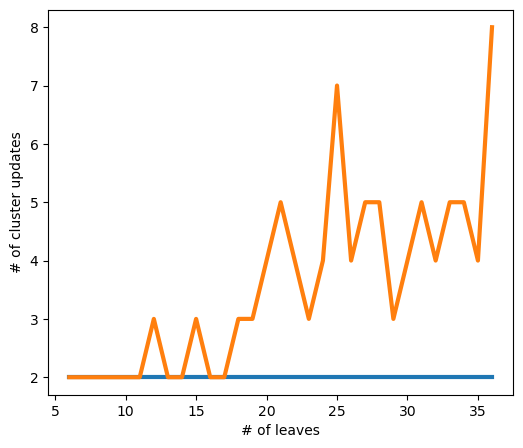

In [35]:
fig,ax = plt.subplots(figsize = (6,5))
ax.plot(leaves, iterations1, linewidth = 3, label = 'Rule Clustering Cost (k-means)')
ax.plot(leaves, iterations2, linewidth = 3, label = 'Rule Clustering Cost (k-means++)')
ax.set_xlabel('# of leaves')
ax.set_ylabel('# of cluster updates')